# Analyizing movie topics to select optimum release data for Maze Runner

## Read in data
### 1) topics_allmovies.csv contains the topic distribution of movies from an LDA analysis of movie reviews

In [129]:
import pandas as pd

topics_allmovies = pd.read_csv('topics_allmovies.csv')

#add title column header
headers = list(topics_allmovies.columns)
headers[0] ='Title'
topics_allmovies.columns = headers
print(topics_allmovies.head())

                           Title   odid    Topic1    Topic2    Topic3  \
0                        Titanic  10100  0.067890  0.023853  0.012844   
1                The Dark Knight  20100  0.754413  0.006140  0.005372   
2         Star Wars Ep. I: The P  60100  0.015385  0.017949  0.017949   
3  Pirates of the Caribbe (2006)  70100  0.026667  0.036667  0.073333   
4          Transformers: Revenge  90100  0.039801  0.034826  0.034826   

     Topic4    Topic5    Topic6    Topic7    Topic8    Topic9   Topic10  
0  0.012844  0.016514  0.012844  0.012844  0.033028  0.796330  0.011009  
1  0.006907  0.004605  0.203377  0.004605  0.006140  0.004605  0.003837  
2  0.558974  0.276923  0.035897  0.033333  0.017949  0.012821  0.012821  
3  0.046667  0.040000  0.016667  0.663333  0.016667  0.020000  0.060000  
4  0.054726  0.606965  0.059701  0.029851  0.049751  0.024876  0.064677  


### 2) opus_movies.txt contains various information for each movie (release date, production cost,....

In [134]:
# fileText = None
# with open('opus_movies.txt') as file:
#     fileText = file.read()

    
# for line in fileText.split('\n'):
#     print(line)

movieInfo = pd.read_csv('opus_movies.csv')
movieInfo.head().T


,0,1,2,3,4
odid,10100,20100,60100,70100,90100
display_name,Titanic,The Dark Knight,Star Wars Ep. I: The Phantom Menace,Pirates of the Caribbean: Dead Man's Chest,Transformers: Revenge of the Fallen
release_date,4/4/2012,7/18/2008,2/10/2012,7/7/2006,6/24/2009
release_pattern,Wide,Wide,Wide,Wide,Wide
distributor,Paramount Pictures,Warner Bros.,20th Century Fox,Walt Disney,Paramount Pictures
movie_url,Titanic,Dark-Knight-The,Star-Wars-Ep-I-The-Phantom-Menace,Pirates-of-the-Caribbean-Dead-Mans-Chest,Transformers-Revenge-of-the-Fallen
production_year,1997,2008,1999,2006,2009
running_time,194,152,133,151,149
sequel,0,1,1,1,1
opening_weekend_revenue,28638131,158411483,64810970,135634554,108966307


## Measure similarity between Maze Runner and other movies using Euclidean distance

In [133]:
import numpy as np
import matplotlib.pyplot as plt

#convert to numpy arrays
movieTitles = np.array(topics_allmovies['Title'])
print(movieTitles.shape)
movieOdid = np.array(topics_allmovies['odid'])
print(movieTitles.shape)
movieTopics = np.array(topics_allmovies[list(topics_allmovies.columns)[2:12]])
print(movieTopics.shape)


#remove maze runner from both arrays and get Topics
mazeRunnerTopics = movieTopics[movieTitles == 'The Maze Runner']
movieTopics = movieTopics[movieTitles != 'The Maze Runner']
movieTitles = movieTitles[movieTitles != 'The Maze Runner']

print(mazeRunnerTopics.shape)
print(movieTopics.shape)
print(movieTitles.shape)

#create distance array for distance between MR and other movies
distances = [np.linalg.norm(topics - mazeRunnerTopics) for topics in movieTopics]

#find most related movies using smallest distances
sortedDistances = np.argsort(distances)

#print top five movie titles
print('*** 5 most similar movies ***')
for i in range(5):
    print('\t', movieTitles[sortedDistances[i]])


(1153,)
(1153,)
(1153, 10)
(1, 10)
(1152, 10)
(1152,)
*** 5 most similar movies ***
	 The Twilight Saga: New
	 Daybreakers
	 28 Weeks Later
	 The Conjuring
	 Underworld: Evolution


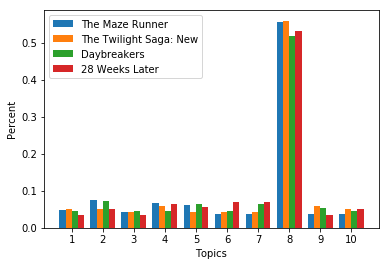

In [132]:
#print bar chart comparing movie topics

#attach other movie topics
MRandTop3 = movieTopics[sortedDistances[0:3]]
graphLabels = [movieTitles[movIdx] for movIdx in sortedDistances[0:3]]


#attach MR topics
MRandTop3 = np.vstack([mazeRunnerTopics, MRandTop3])
graphLabels.insert(0,'The Maze Runner')
graphLabels = np.array(graphLabels)

X = np.arange(1,11)

def subcategorybar(X, vals, labels, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    ax = None
    for i in range(n):
        #print(labels[i])
        #print(len(labels))
        ax = plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", label = labels[i])   
    plt.xticks(_X, X)
    plt.legend()
    plt.xlabel('Topics')
    plt.ylabel('Percent')
    plt.show()
    

subcategorybar(X, MRandTop3, graphLabels)



## Find optimal data to release in 2014

### Score days within 2014 using the similarity of movies being released around that date

    Higher scores for dates with higher similarity movies being released
    
    Use decaying function to approximate the draw of movies over time
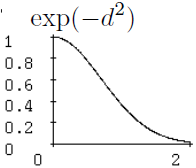

In [173]:
from datetime import datetime

#add dateTime info to movies
movieInfo["dateTime"] = [datetime.strptime(i, '%m/%d/%Y') for i in movieInfo["release_date"]]
movieInfo["release_year"] = [int(dt.isocalendar()[0]) for dt in movieInfo["dateTime"]]
movieInfo["release_weekOfYear"] = [int(dt.isocalendar()[1]) for dt in movieInfo["dateTime"]]
movieInfo["release_DOW"] = [int(dt.isocalendar()[2]) for dt in movieInfo["dateTime"]]

# #add in similarity score to movies  
movieInfo["simil_To_MR"] = np.zeros(len(movieInfo))

# add in movie topic
movieInfo["topic"] = (np.zeros(len(movieInfo)) - 1)  # set to -1 by default

In [230]:
#convert distances to similarity score 0-1. with 1 being the closest in topic space
distances = np.array(distances)
similarityScore = distances/distances.max()
similarityScore = abs(1 - similarityScore)

#iterate through the odid list to get idex of each similarity score
for odid, score, topics in zip(movieOdid, similarityScore, movieTopics):
    #print(score)
    movieInfo.loc[movieInfo['odid']==odid, 'simil_To_MR'] = score
    movieInfo.loc[movieInfo['odid']==odid, 'topic'] = (np.argmax(topics) + 1) #assign 1 topic to movie

# add topic to maze Runner
movieInfo.loc[movieInfo['display_name']=='The Maze Runner', 'topic'] = (np.argmax(mazeRunnerTopics) + 1) 
    
    
# sort by similarity to check
#movieInfo = movieInfo.sort_values('simil_To_MR', ascending=False)

#sort by date
movieInfo = movieInfo.sort_values('dateTime', ascending=False)

#delete movies that are not found in movie topics analysis
movieInfo = movieInfo[movieInfo['topic'].notnull()]
movieInfo



,odid,display_name,release_date,release_pattern,distributor,movie_url,production_year,running_time,sequel,opening_weekend_revenue,...,movieId,imdb_moviemeter,imdb_rating,imdb_votes,dateTime,release_year,release_weekOfYear,release_DOW,simil_To_MR,topic
1227,192510100,Exodus: Gods and Kings,12/12/2014,Wide,20th Century Fox,Exodus-Gods-and-Kings,2014,150.0,0,24115934,...,116887.0,NaN,NaN,NaN,2014-12-12,2014,50,5,0.575339,1.0
1275,208800100,The Pyramid,12/5/2014,Wide,20th Century Fox,Pyramid-The,2014,89.0,0,1369935,...,113769.0,NaN,NaN,NaN,2014-12-05,2014,49,5,0.320328,1.0
1251,198210100,Horrible Bosses 2,11/26/2014,Wide,Warner Bros.,Horrible-Bosses-2,2014,108.0,1,15457418,...,117590.0,NaN,NaN,NaN,2014-11-26,2014,48,3,0.425367,9.0
1163,181330100,Penguins of Madagascar,11/26/2014,Wide,20th Century Fox,Penguins-of-Madagascar,2014,92.0,0,25447444,...,117851.0,NaN,NaN,NaN,2014-11-26,2014,48,3,0.490086,3.0
1152,178290100,The Hunger Games: Mockingjay - Part 1,11/21/2014,Wide,Lionsgate,Hunger-Games-Mockingjay-Part-1-The,2014,123.0,1,121897634,...,116823.0,NaN,NaN,NaN,2014-11-21,2014,47,5,0.821690,8.0
1263,200420100,Dumb and Dumber To,11/14/2014,Wide,Universal,Dumb-and-Dumber-To,2014,110.0,1,36111775,...,116977.0,NaN,NaN,NaN,2014-11-14,2014,46,5,0.526049,9.0
1277,210220100,Beyond the Lights,11/14/2014,Wide,Relativity,Beyond-the-Lights,2014,116.0,0,6200284,...,117456.0,NaN,NaN,NaN,2014-11-14,2014,46,5,0.582654,8.0
1226,191970100,Big Hero 6,11/7/2014,Wide,Walt Disney,Big-Hero-6,2014,108.0,0,56215889,...,115617.0,NaN,NaN,NaN,2014-11-07,2014,45,5,0.765065,8.0
1254,198630100,Before I Go to Sleep,10/31/2014,Wide,Clarius Entertainment,Before-I-Go-to-Sleep,2013,92.0,0,1843347,...,114007.0,NaN,NaN,NaN,2014-10-31,2014,44,5,0.495215,4.0
1276,210210100,Nightcrawler,10/31/2014,Wide,Open Road,Nightcrawler,2014,117.0,0,10441000,...,115569.0,NaN,NaN,NaN,2014-10-31,2014,44,5,0.556405,9.0


8

In [259]:
#score dates by sum of similar movies in the surrouding weeks
week2014Scores = []
weekOpWeekendRevForGenre = []
weekMovieCount = []
movieCount2014 = []

mazeRunnerTopic = int(movieInfo.loc[movieInfo['display_name']=='The Maze Runner', 'topic'])

for week in range(1,53):
    sumOfSimilarities = 0
    count = 0
    opWeekendSum = 0
    opWeekCount = 0
    for idx in list(movieInfo.index.values):
        movieWeek = int(movieInfo.loc[idx, 'release_weekOfYear'])
        if (int(movieInfo.loc[idx, 'release_year']) == 2014) and (movieInfo.loc[idx, 'display_name'] != 'The Maze Runner'):
            if ((week - 1) <= movieWeek) and  (movieWeek <= (week + 1)):
                #print(week, movieWeek)
                sumOfSimilarities += float(movieInfo.loc[idx, 'simil_To_MR'])
            if week == movieWeek:
                count += 1
        if week == movieWeek and int(movieInfo.loc[idx, 'topic']) == mazeRunnerTopic:
#             print("\t date:",  movieInfo.loc[idx, 'release_date'])
#             print("\t year:", movieInfo.loc[idx, 'release_year'])
#             print("\t movieWeek:", movieWeek)
#             print("\t title:", movieInfo.loc[idx, 'display_name'])
#             print("\t topic:", movieInfo.loc[idx, 'topic'])
            opWeekCount += 1
            opWeekendSum += float(movieInfo.loc[idx, 'opening_weekend_revenue'])
    if (opWeekCount != 0):
        weekOpWeekendRevForGenre.append((opWeekendSum / opWeekCount))
    else:
        weekOpWeekendRevForGenre.append(0)
    weekMovieCount.append(opWeekCount)
    week2014Scores.append(sumOfSimilarities)
    movieCount2014.append(count)

print("Number of topic 8 movies:",len(movieInfo[movieInfo['topic'] == 8]))
print("Number of movies released in 2014:",len(movieInfo[movieInfo['release_year'] == 2014]))
print(week2014Scores)
print(sum(movieCount2014))

Number of topic 8 movies: 116
Number of movies released in 2014: 104
[1.0622471482041624, 2.7298156316001436, 2.823644227160553, 3.3697213220830857, 3.631854049582954, 4.554804143392689, 3.999692008858362, 2.8609342959398756, 2.3640398346594176, 2.937623030990596, 3.5026515891479493, 3.7850074076363986, 2.9102749136685357, 3.111706528842314, 3.862644145987862, 5.2012511738868055, 4.048958223500867, 2.4996901853467692, 1.9131937685932665, 2.2913263927262078, 2.6356723436339333, 2.6907414971201957, 2.8405068411497956, 3.018150071064537, 2.5861198070501303, 3.336336110798908, 2.8782876735332845, 3.8614566790723277, 3.2594672137681098, 3.5138783115590337, 4.058939839100474, 4.635327760972881, 5.265733795637357, 4.685428765565153, 3.0278053161630876, 2.0758531363183517, 1.683295256308328, 2.7369665585630685, 3.628845740464948, 4.0281786032395175, 4.5463021941551816, 4.230685659661101, 3.7409742570655453, 2.9342440401583634, 2.9253865590396435, 2.6954569353552484, 2.84584509820667, 2.0574705

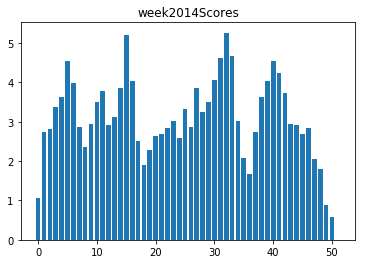

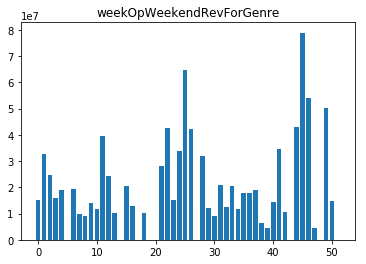

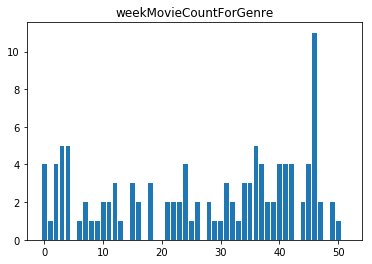

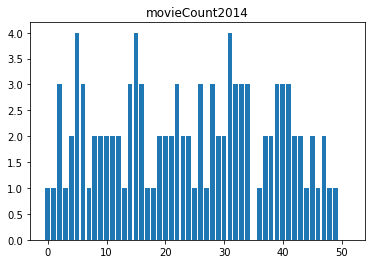

45


In [265]:
import matplotlib.pyplot as plt

plt.bar(range(0,len(week2014Scores)), week2014Scores)
plt.title('week2014Scores')
plt.show()
plt.bar(range(0,len(movieCount)), weekOpWeekendRevForGenre)
plt.title('weekOpWeekendRevForGenre')
plt.show()
plt.bar(range(0,len(movieCount)), weekMovieCount)
plt.title('weekMovieCountForGenre')
plt.show()
plt.bar(range(0,len(movieCount)), movieCount2014)
plt.title('movieCount2014')
plt.show()
print(np.argmax(np.array(weekOpWeekendRevForGenre)))

### Score dates by historical gross revenue for movies similar (same Genre) to "The Maze Runner"
    
    use movie production cost and rating to normalize

In [ ]:
#create scatter plot with dayOfYear and profitability



